In [8]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#from source.utils import *
from source.preprocess import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [10]:
path = "../../Desktop/DLC_social_1/"
path2 = "../../Desktop/DLC_social_2/"

# Set up and design the project

In [11]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [12]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [13]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.53 s, sys: 727 ms, total: 3.26 s
Wall time: 1.11 s


In [14]:
%%time
DLC_social_2 = project(path=path2,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5')

CPU times: user 6.59 s, sys: 950 ms, total: 7.54 s
Wall time: 1.67 s


# Run project

In [15]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.81 s, sys: 620 ms, total: 10.4 s
Wall time: 10.7 s


source.preprocess.coordinates

In [16]:
%%time
DLC_social_2_coords = DLC_social_2.run(verbose=True)
print(DLC_social_2_coords)
type(DLC_social_2_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
DLC analysis of 31 videos
CPU times: user 6.11 s, sys: 343 ms, total: 6.45 s
Wall time: 6.57 s


source.preprocess.coordinates

# Generate coords

In [17]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

ptest2 = DLC_social_2_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest2._type

CPU times: user 1.41 s, sys: 90.7 ms, total: 1.5 s
Wall time: 1.39 s


'coords'

In [18]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

dtest2 = DLC_social_2_coords.get_distances(speed=0, length='00:10:00')
dtest2._type

CPU times: user 875 ms, sys: 555 ms, total: 1.43 s
Wall time: 1.43 s


'dists'

In [19]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

atest2 = DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest2._type

CPU times: user 206 ms, sys: 110 ms, total: 316 ms
Wall time: 316 ms


'angles'

# Visualization playground

In [20]:
#ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [21]:
#Plot animation of trajectory over time with different smoothings
#plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
#         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Mouse Center Trajectory using different exponential smoothings')
#plt.legend()
#plt.show()

# Dimensionality reduction playground

In [22]:
#pca = ptest.pca(4, 1000)

In [23]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [24]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [25]:
mtest2 = merge_tables(DLC_social_2_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [26]:
#pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [27]:
pttest = mtest.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=10,
                          shift=0, standard_scaler=True)
pttest.shape

(70504, 11, 28)

In [28]:
pttest2 = mtest2.preprocess(window_size=11, window_step=1, filter="gaussian", sigma=10,
                            shift=0, standard_scaler=True)
pttest2.shape

(465021, 11, 28)

In [29]:
#plt.plot(pttest[2,:,2], label='normal')
#plt.plot(pptest[2,:,2], label='gaussian')
#plt.legend()
#plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [30]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [ ]:
NAME = 'Baseline_AE_512_wu10_slide10_gauss_fullval'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

In [ ]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [ ]:
ae.summary()

In [35]:
encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(pttest.shape,
                                                                               loss='ELBO+MMD',
                                                                               number_of_components=1,
                                                                               kl_warmup_epochs=10,
                                                                               mmd_warmup_epochs=10,
                                                                               predictor=False).build()
gmvaep.build(pttest.shape)

ValueError: in user code:

    /Users/lucas_miranda/PycharmProjects/deepof/source/model_utils.py:61 call  *
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:180 wrapper  **
        return target(*args, **kwargs)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2984 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:5587 mat_mul
        name=name)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /Users/lucas_miranda/opt/anaconda3/envs/Machine_Learning/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 64 and 128 for '{{node dense_transpose_1_1/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true](batch_normalization_9_1/Identity, dense_transpose_1_1/MatMul/ReadVariableOp)' with input shapes: [?,64], [256,128].


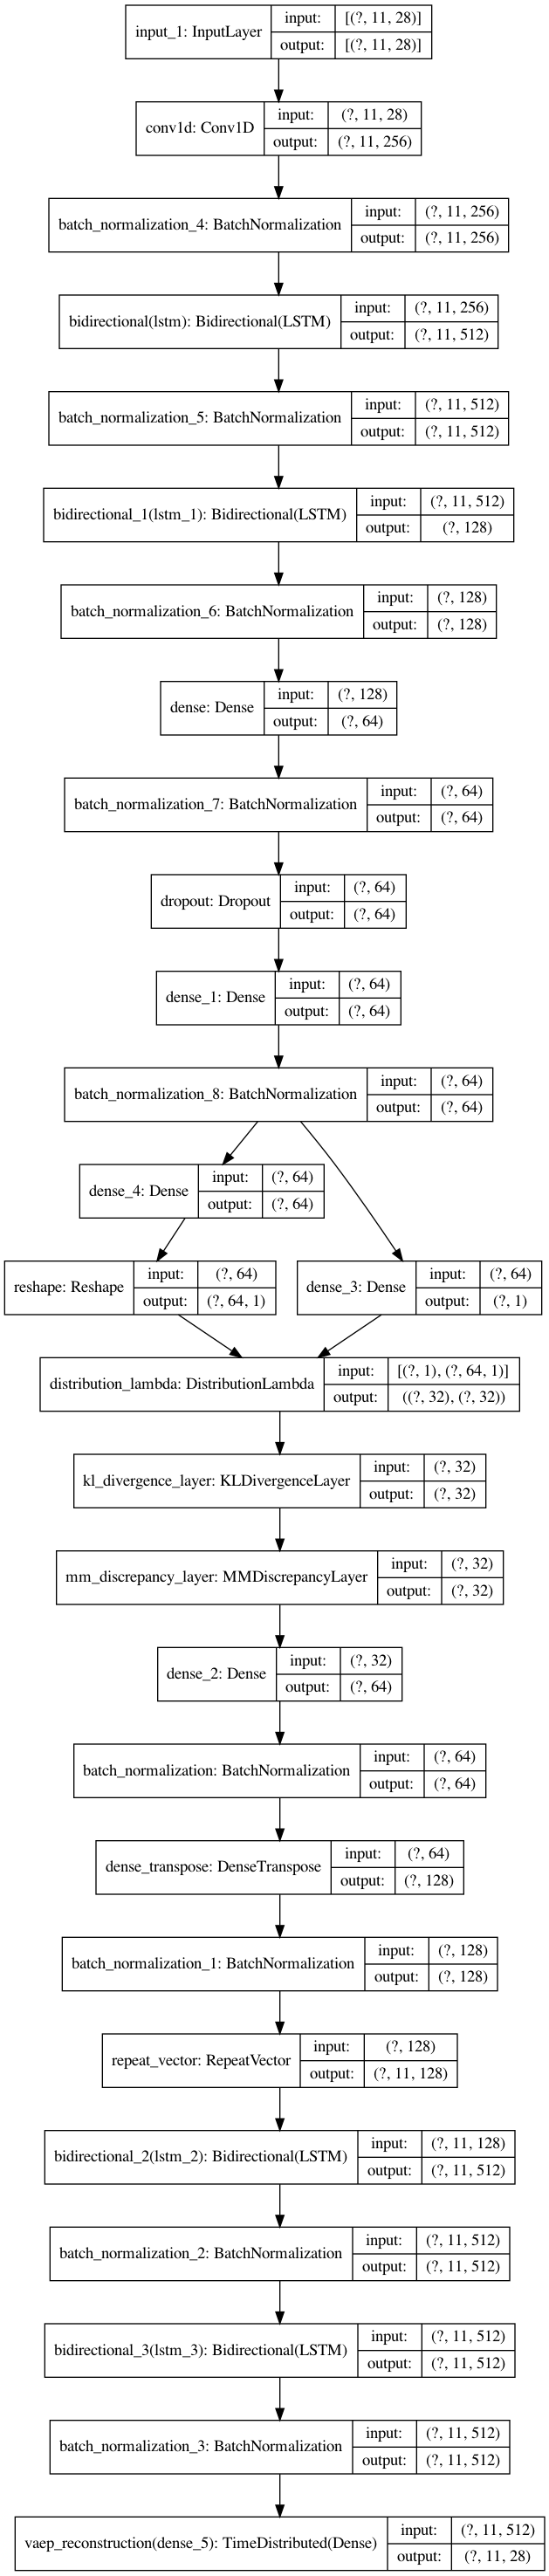

In [36]:
tf.keras.utils.plot_model(gmvaep, show_shapes=True)

In [ ]:
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-3 * 10**(epoch / 20))

In [ ]:
# tf.config.experimental_run_functions_eagerly(False)
history = ae.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
                   validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
                   callbacks=[tensorboard_callback])

In [ ]:
# #GMVAEP witout prediction
# #tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttest[:-1], y=pttest[:-1], epochs=100, batch_size=512, verbose=1,
#                   validation_data=(pttest2[:-1], pttest2[:-1]),
#                   callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

In [ ]:
# GMVAEP with prediction
# tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttest[:-1], y=[pttest[:-1],pttest[1:]], epochs=100, batch_size=512, verbose=1,
#                      validation_data=(pttest2[:-1], [pttest2[:-1],pttest2[1:]]),
#                      callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

## Encoding interpretation playground

In [ ]:
# encodings = encoder.predict(pttest)
# clusters  = np.argmax(grouper.predict(pttest), axis=1)

In [ ]:
# from collections import Counter
# Counter(clusters)

In [ ]:
# %matplotlib notebook
# # This import registers the 3D projection, but is otherwise unused.
# from mpl_toolkits.mplot3d import Axes3D 

# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# encs = encodings[:]
# ax.scatter(encs[:,0],encs[:,1],encs[:,2], c=clusters[:])

# ax.set_xlabel('Encoding 0')
# ax.set_ylabel('Encoding 1')
# ax.set_zlabel('Encoding 2')

# plt.show()